### DoRothEA VS CollecTRI

&emsp;&emsp;&emsp;



<br></br>

Loading packages

In [ ]:
#@title Install necessary libraries
#@markdown
!pip install scanpy
!pip install git+https://github.com/saezlab/decoupler-py.git
!pip install pydeseq2
!pip install adjustText
!pip install omnipath

In [1]:
#@title Import Necessary libraries
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData

# Differential Expression Analysis (DESeq2)
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import warnings
warnings.filterwarnings("ignore")

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

ValueError: ignored

In [4]:
# Retrieve DoRothEA gene regulatory network
dorothea = dc.get_dorothea(organism='human')
dorothea

0.00B [00:00, ?B/s]

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


Download the data from GEO

In [ ]:
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
!gzip -d -f counts.txt.gz
!mv counts.txt datasets/counts.txt

--2023-08-22 02:02:14--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1.5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1.50M  1.42MB/s    in 1.1s    

2023-08-22 02:02:19 (1.42 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]



Process the data

In [ ]:
# Read raw data and process it
adata = pd.read_csv('counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


In [ ]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()

# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


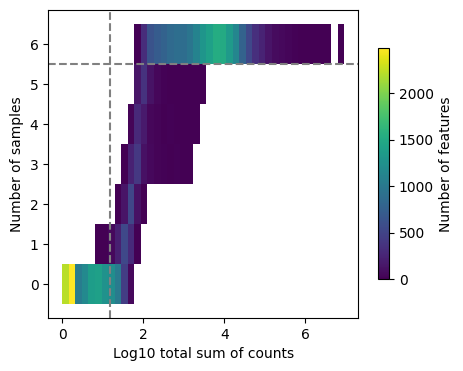

In [ ]:
# Quality Control (optional but recommended)
# --- only the genes in the upper-right corner are going to be kept
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

In [ ]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'

Differential expression analysis

In [ ]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)

In [ ]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 224.40 seconds.

Fitting dispersion trend curve...
... done in 9.87 seconds.

Fitting MAP dispersions...
... done in 206.50 seconds.

Fitting LFCs...
... done in 14.29 seconds.

Refitting 0 outliers.



In [ ]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["condition", 'treatment', 'control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 4.51 seconds.



Log2 fold change & Wald test p-value: condition treatment vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.067094,0.294257,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.086227,0.249617,-0.345438,0.729765,0.801351
CICP27,106.257057,0.144798,0.177248,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.634443,0.286075,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.579098,0.270626,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.445816,0.278378,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.343227,0.287943,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.323882,0.302438,-1.070903,0.284213,0.387995


In [ ]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_treatment_vs_control')

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition treatment vs control


... done in 30.00 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


In [ ]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


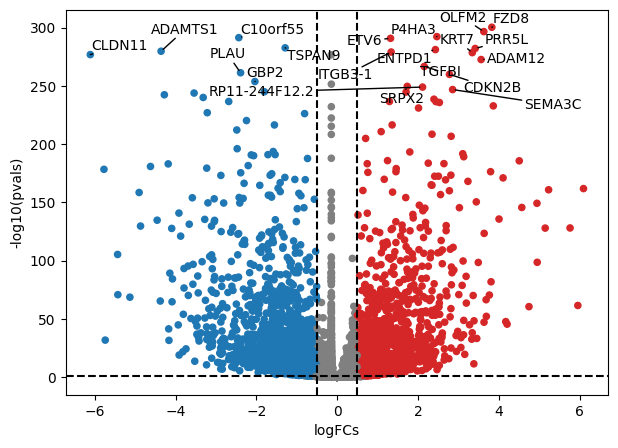

In [ ]:
# Show Vocano Plot
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

In [ ]:
# Obtain gene level statistics to perform enrichment analysis
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,0.22801,-0.345438,0.816925,-2.217747,2.139848,-0.422515,-1.373661,-0.53866,-2.845663,-3.862065,...,-1.472827,0.550156,0.704443,1.049607,-1.283784,-1.601475,-1.191996,-1.070903,-1.49019,-2.362806


CollecTRI network

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
treatment.vs.control,-1.757384,-2.041384,-1.317279,-2.718626,-2.338566,0.178862,-6.440889,1.410645,2.23343,-0.704304,...,-1.164067,-0.933561,2.687689,1.49982,-1.249087,-1.407577,-0.820753,0.485726,2.157699,0.86518


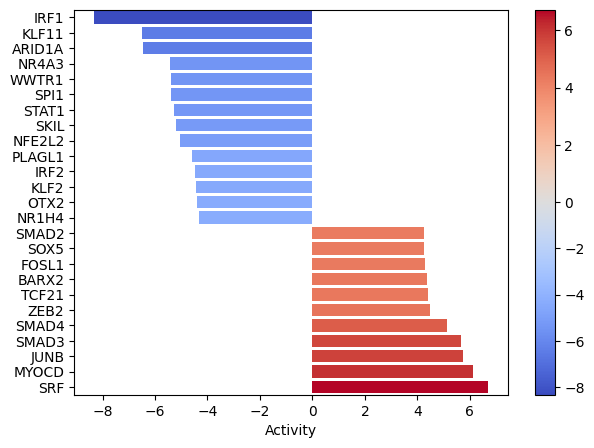

In [ ]:
# Show the obtained scores for the top active/inactive transcription factors
dc.plot_barplot(tf_acts, 'treatment.vs.control', top=25, vertical=True)

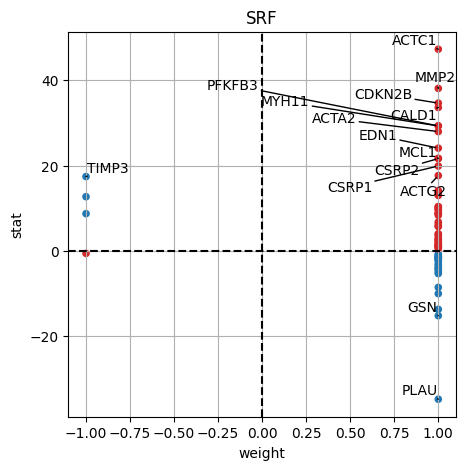

In [ ]:
# Manually inspect the downstream targets of each transcription factor
dc.plot_targets(results_df, stat='stat', source_name='SRF', net=collectri, top=15)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


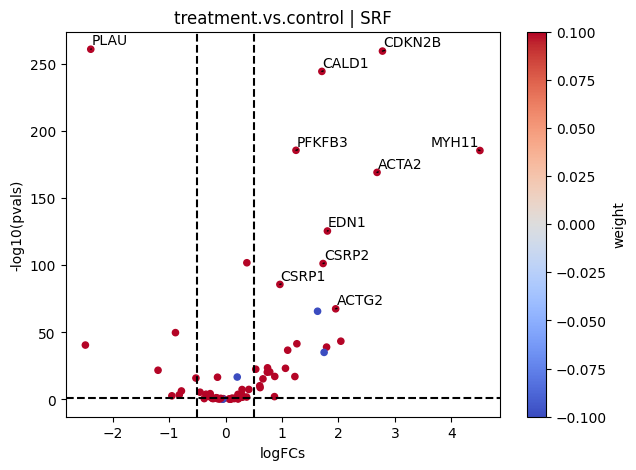

In [ ]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(logFCs, pvals, 'treatment.vs.control', name='SRF', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)